In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
from lid_driven_cavity import operators, states, postprocessing
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
np.set_printoptions(linewidth=2000, threshold=5000, precision=6)

Inputs

In [23]:
Re = 5000  # Reynolds number
N = 20  # number of cells in one direction
h = 1.0 / N  # grid spacing
k = 0.001  # timestep size
n = 0  # timestep index
max_n = 100  # maximum timestep index

In [24]:
# ------------------
# ----- Setup -----
# ----------------

# 1. Assume phi_n, u_n, v_n are known at all points
phi_n = states.State(np.zeros((N+2, N+2)), Nx=N+2, Ny=N+2)
u_n   = states.State(np.zeros((N+2, N+1)), Nx=N+1, Ny=N+2)
v_n   = states.State(np.zeros((N+1, N+2)), Nx=N+2, Ny=N+1)

# 2. Assume Gx_phi_n, Gy_phi_n are known at all points
Gx_phi_n = operators.compute_gradient_x(phi_n)
Gy_phi_n = operators.compute_gradient_y(phi_n)
Gx_phi_n = states.State(Gx_phi_n.get_matrix()[:, 1:], Nx=Gx_phi_n.Nx-1, Ny=Gx_phi_n.Ny)
Gy_phi_n = states.State(Gy_phi_n.get_matrix()[:-1, :], Nx=Gy_phi_n.Nx, Ny=Gy_phi_n.Ny-1)

# 3. Assume Nu_nm1, Nv_nm1 are known at interior points
Nu_nm1 = states.State(np.zeros((N, N-1)), Nx=N-1, Ny=N)
Nv_nm1 = states.State(np.zeros((N-1, N)), Nx=N, Ny=N-1)
Nu_nm1.pad_boundaries()
Nv_nm1.pad_boundaries()


n=0
Divergence =  0.0027562259924364296


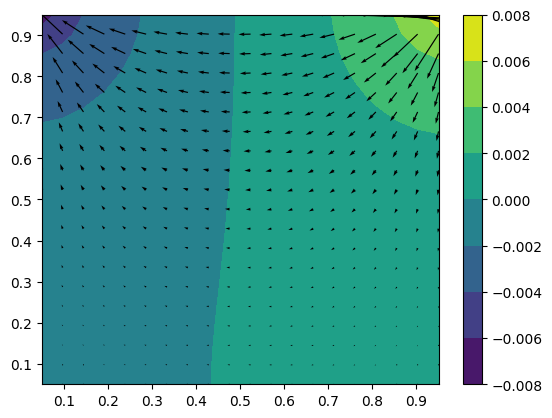

n=1
Divergence =  0.010134325462541031


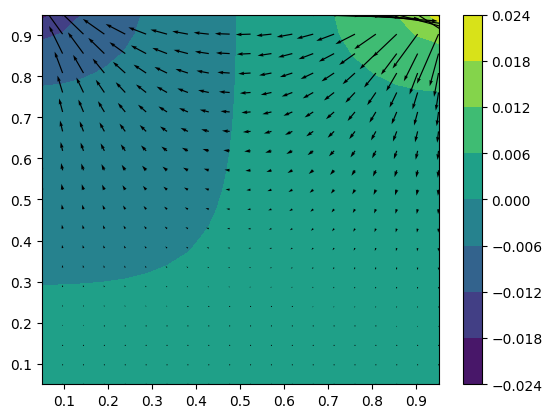

n=2
Divergence =  0.023240798857331074


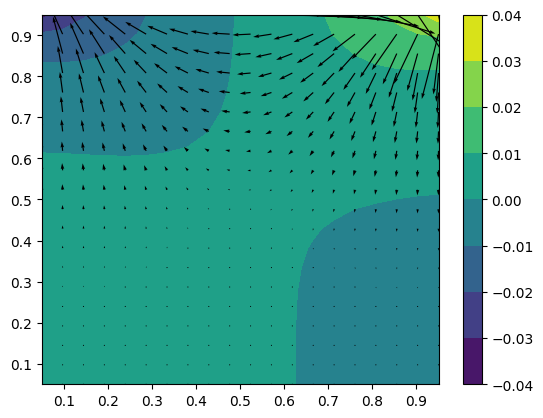

n=3
Divergence =  0.04774881178558666


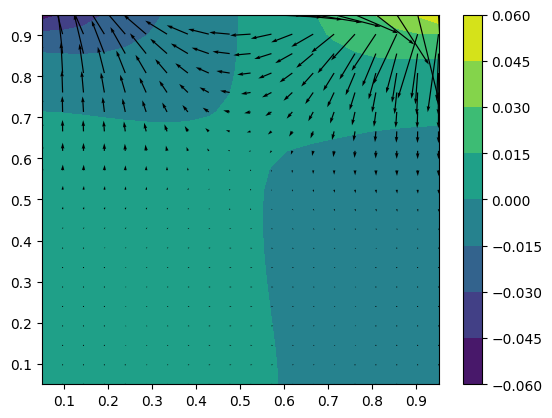

n=4
Divergence =  0.09471484553037861


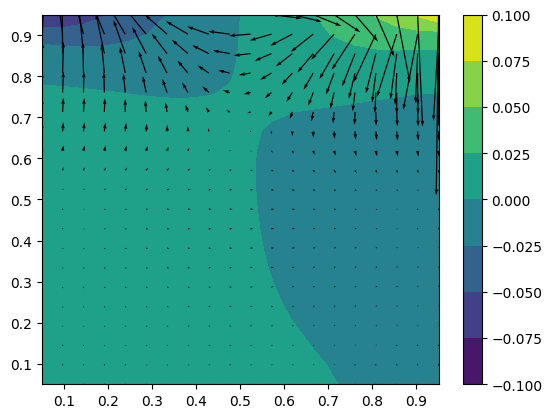

n=5
Divergence =  0.18593079013700078


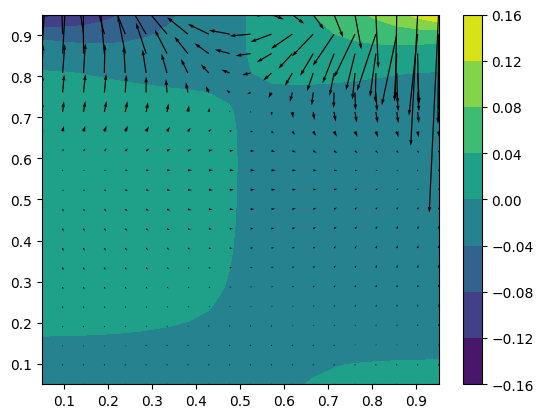

n=6
Divergence =  0.36455559590024206


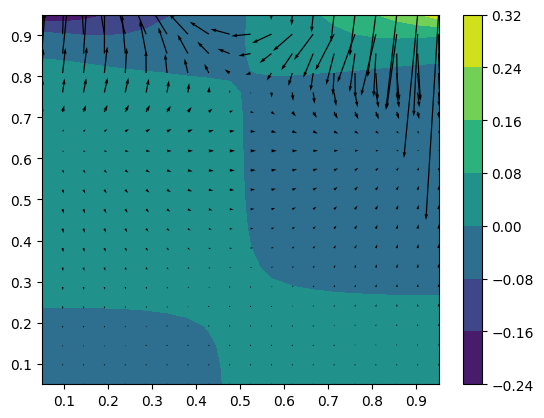

n=7
Divergence =  0.7163386626462789


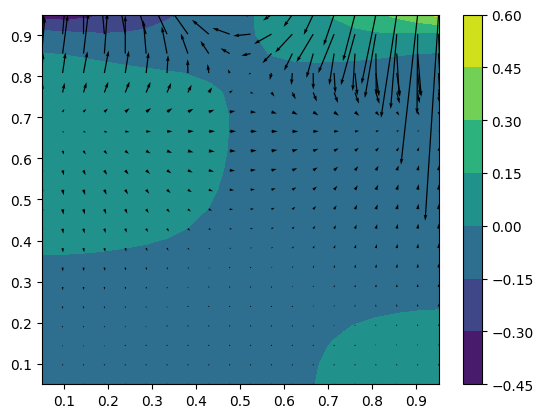

n=8
Divergence =  1.4120827520011305


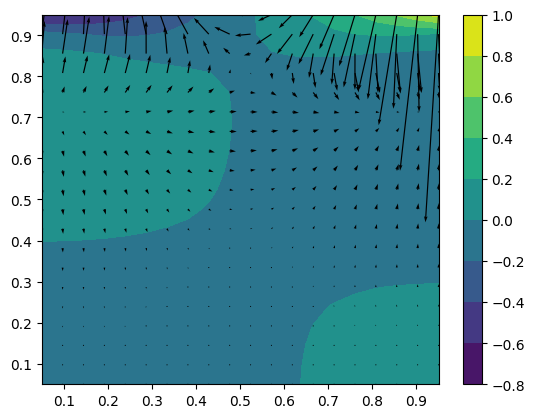

n=9
Divergence =  2.7927886305314886


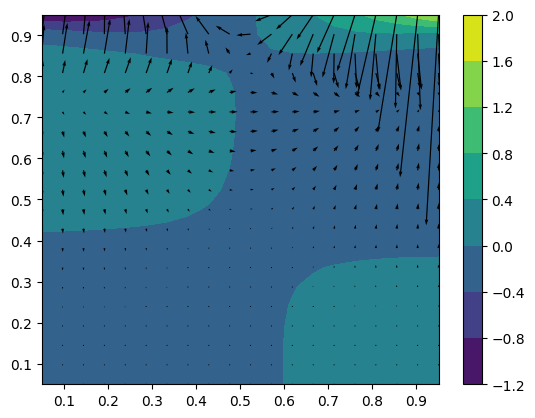

n=10
Divergence =  5.540863371239525


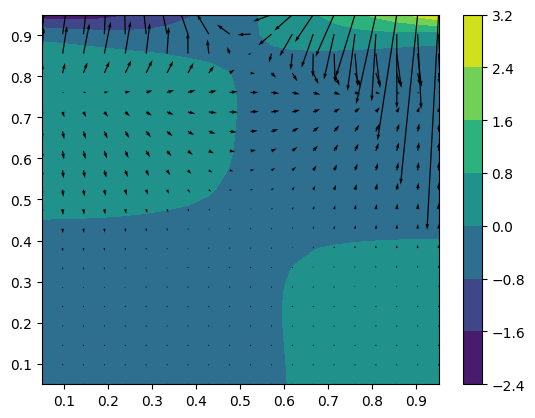

n=11
Divergence =  11.025825549593328


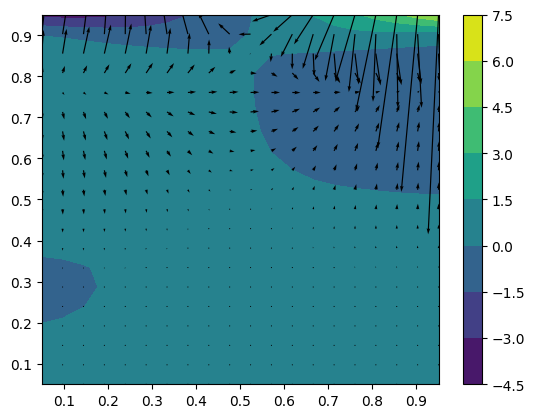

n=12
Divergence =  22.007100868577734


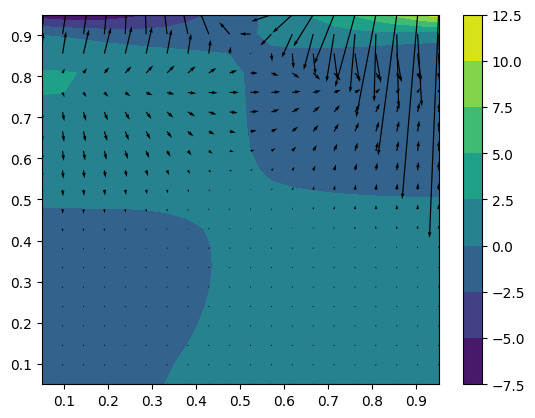

n=13
Divergence =  44.078856301183116


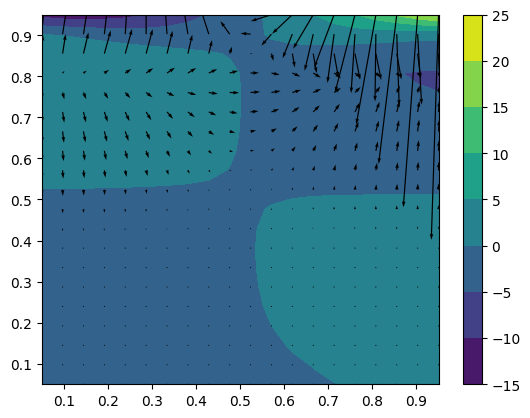

n=14
Divergence =  88.69250648052856


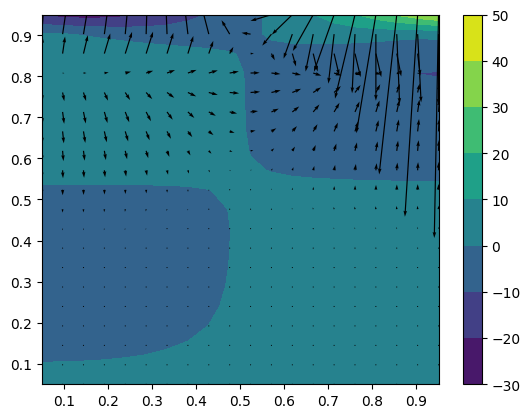

n=15
Divergence =  179.6225856024589


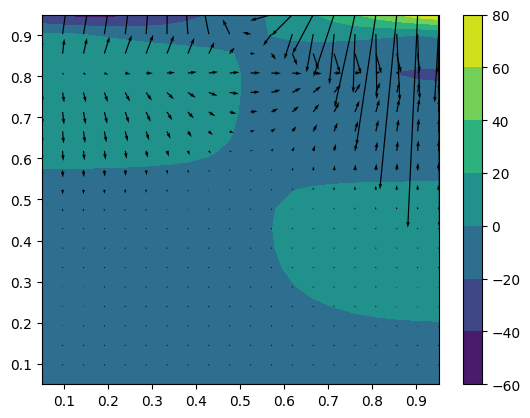

n=16
Divergence =  367.1038982829021


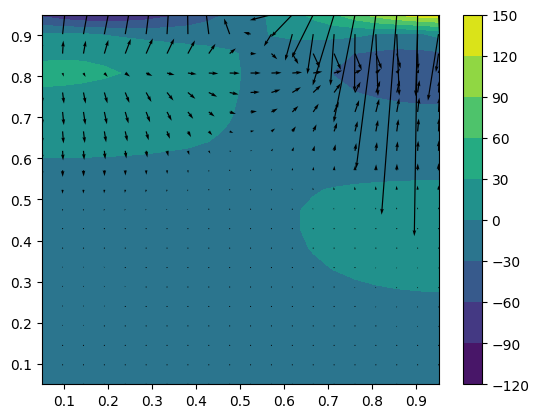

n=17
Divergence =  762.6942691186476


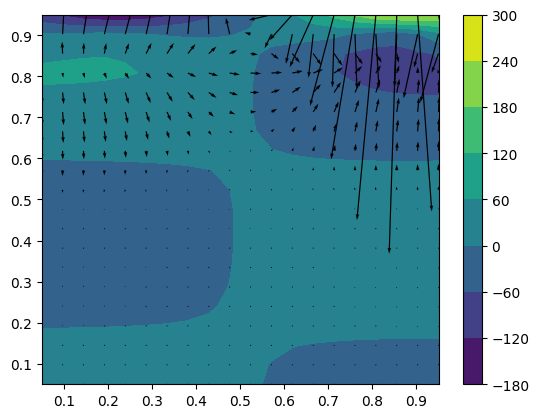

n=18
Divergence =  1767.6307459936238


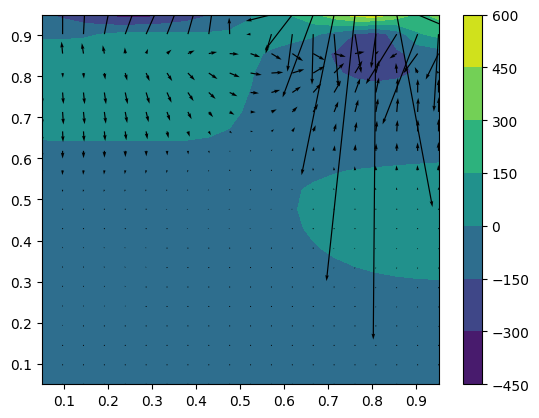

n=19
Divergence =  8277.47688155345


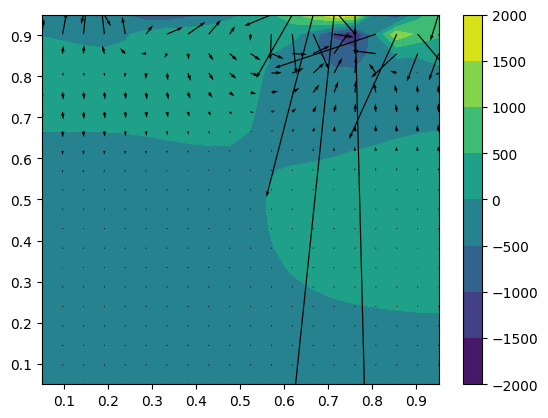

n=20
Divergence =  199046.8703398506


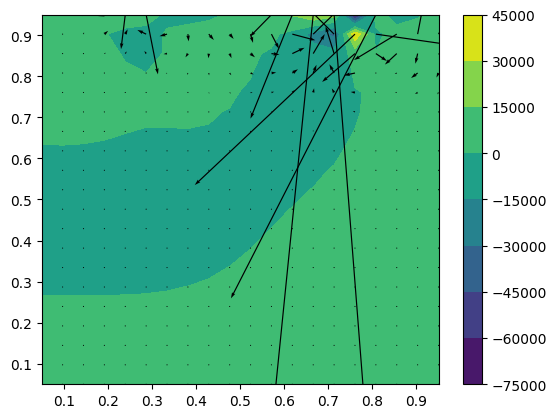

n=21
Divergence =  267598202.19796777


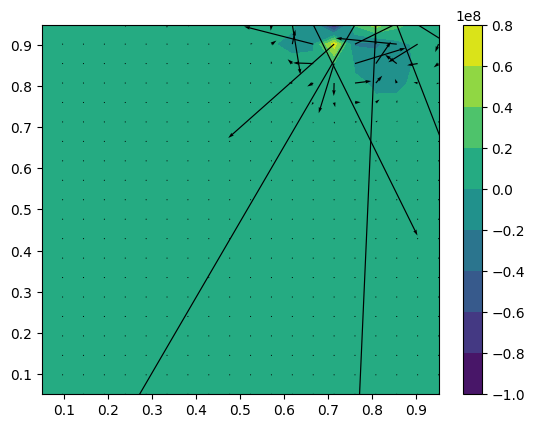

n=22
Divergence =  342017776096139.06


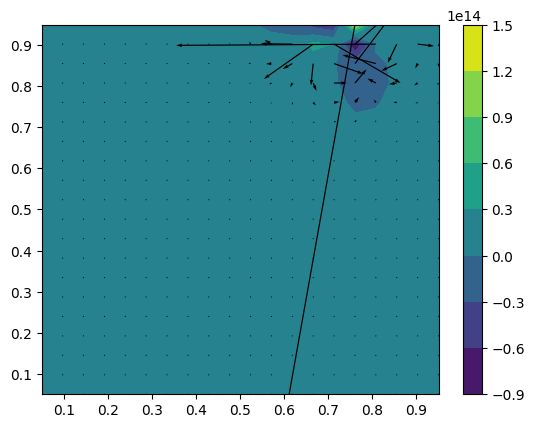

n=23
Divergence =  6.986024983138253e+26


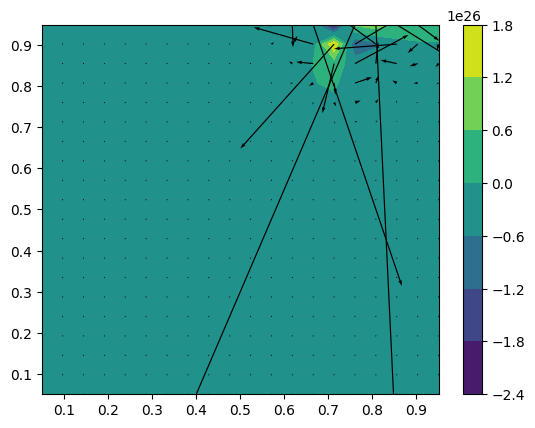

n=24
Divergence =  3.143258399833181e+51


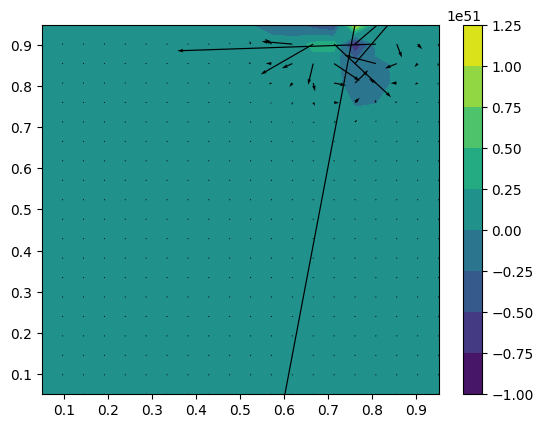

n=25
Divergence =  6.570244292856632e+100


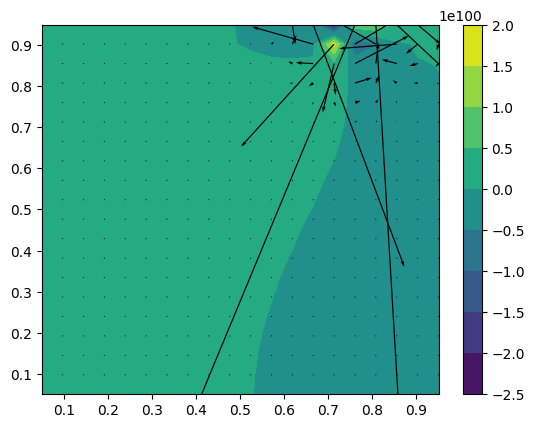

n=26
Divergence =  inf


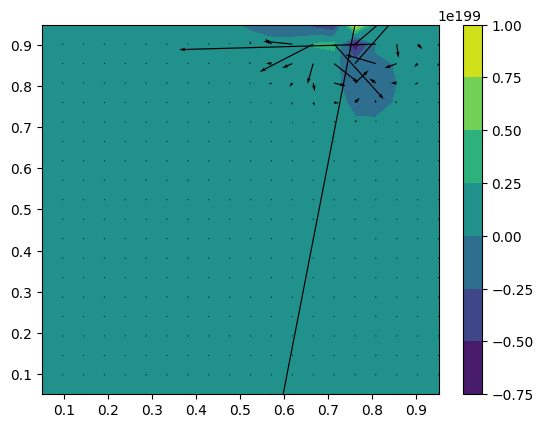

n=27


ValueError: array must not contain infs or NaNs

In [25]:
for n in range(max_n):
    print(f"n={n:d}")

    # ----------------------------
    # ----- Prediction step -----
    # --------------------------

    # 4. Compute u_hat_n, v_hat_n at interior points
    u_hat_n = operators.compute_interpolated_x(u_n)
    v_hat_n = operators.compute_interpolated_y(v_n)

    # 5. Compute Nu, Nv at interior points
    Nu = operators.compute_Nu(u_n, v_hat_n, h)
    Nv = operators.compute_Nv(v_n, u_hat_n, h)

    # 7. Solve for u_star at all points

    # Compute explicit Laplacian action on u_n
    Lu = operators.compute_laplace(u_n)

    # Assemble RHS
    b = (k/2) * (3*Nu.get_matrix()-Nu_nm1.get_matrix()) + u_n.get_matrix() + (k/2)*(1/Re)*Lu.get_matrix()
    # Replace boundary values with zeros
    b = states.strip_boundaries(b)
    b = states.pad_boundaries(b)
    # convert to vector
    b = states.matrix_to_vector(b)

    # Compute implicit Laplacian operator
    laplacian, b = operators.assemble_laplacian_operator_u(b, Nx=N+1, Ny=N+2, h=h)

    # Assemble LHS
    A1 = sp.sparse.eye(laplacian.shape[0], dtype=float, format='csr')
    A2 = (k/2)*(1/Re)*laplacian.get_csr()
    A = A1 - A2

    # Solve implicit step
    u_star = sp.sparse.linalg.spsolve(A, b)
    u_star = states.State(u_star, Nx=N+1, Ny=N+2)

    # Compute explicit Laplacian
    Lv = operators.compute_laplace(v_n)

    # Assemble RHS
    b = (k/2) * (3*Nv.get_matrix()-Nv_nm1.get_matrix()) + v_n.get_matrix() + (k/2)*(1/Re)*Lv.get_matrix()
    # replace boundary values with zeros
    b = states.strip_boundaries(b)
    b = states.pad_boundaries(b)
    # convert to vector
    b = states.matrix_to_vector(b)

    # Compute implicit Laplacian operator
    laplacian, b = operators.assemble_laplacian_operator_v(b, Nx=N+2, Ny=N+1, h=h)

    # Assemble linear system
    A1 = sp.sparse.eye(laplacian.shape[0], dtype=float, format='csr')
    A2 = (k/2)*(1/Re)*laplacian.get_csr()
    A = A1 - A2

    # Solve implicit step
    v_star = sp.sparse.linalg.spsolve(A, b)
    v_star = states.State(v_star, Nx=N+2, Ny=N+1)  # 5, 4

    # ----------------------------
    # ----- Poisson problem -----
    # --------------------------

    # 8. Compute D(u_star) at interior points
    dudx = (u_star.get_matrix()[:, 1:] - u_star.get_matrix()[:, :-1]) / h
    dvdy = (v_star.get_matrix()[1:, :] - v_star.get_matrix()[:-1, :]) / h

    dudx_interior = dudx[1:-1, :]  # remove ghost points (top/bottom rows)
    dvdy_interior = dvdy[:, 1:-1]  # remove ghost points (left/right columns)

    Dstar = dudx_interior + dvdy_interior

    # 9. Solve for phi_np1 for all interior and ghost points

    # Assemble RHS
    b_interior = Dstar / k
    # replace boundary values with zeros
    b = states.pad_boundaries(b_interior)
    # convert to vector
    b = states.matrix_to_vector(b)

    # Compute implicit laplace operator
    Lphi, b = operators.assemble_laplacian_operator_phi(b, Nx=N+2, Ny=N+2, h=h, k=k)
    A = Lphi.get_csr()

    # Solve Poisson problem
    phi_np1 = sp.sparse.linalg.spsolve(A, b)
    phi_np1 = states.State(phi_np1, Nx=N+2, Ny=N+2)

    # ----------------------------
    # ----- Correction step -----
    # --------------------------

    # 10. Compute Gx_phi_np1, Gy_phi_np1 at all points
    Gx_phi_np1 = operators.compute_gradient_x(phi_np1)
    Gy_phi_np1 = operators.compute_gradient_y(phi_np1)

    # Remove ghost-node related extra row and column
    Gx_phi_np1_matrix = Gx_phi_np1.get_matrix()[:, 1:]  # remove spurious first column from ghost nodes
    Gy_phi_np1_matrix = Gy_phi_np1.get_matrix()[:-1, :]  # remove spurious bottom row from ghost nodes

    # 11. Correct u_star to get u_np1 at all points
    u_np1_matrix = u_star.get_matrix() - k * Gx_phi_np1_matrix
    v_np1_matrix = v_star.get_matrix() - k * Gy_phi_np1_matrix

    # Confirm near-zero divergence
    dudx = (u_np1_matrix[:, 1:] - u_np1_matrix[:, :-1]) / h
    dvdy = (v_np1_matrix[1:, :] - v_np1_matrix[:-1, :]) / h

    dudx_interior = dudx[1:-1, :]  # remove ghost points (top/bottom rows)
    dvdy_interior = dvdy[:, 1:-1]  # remove ghost points (left/right columns)

    divergence = dudx_interior + dvdy_interior
    print(f"Divergence = ", sp.linalg.norm(divergence, ord="fro"))

    # ------------------------
    # ----- Bookkeeping -----
    # ----------------------

    # Update time index
    n = n + 1

    # Update states
    phi_n = states.State(phi_np1.vector, Nx=phi_n.Nx, Ny=phi_n.Ny)
    u_n = states.State(u_np1_matrix, Nx=u_n.Nx, Ny=u_n.Ny)
    v_n = states.State(v_np1_matrix, Nx=v_n.Nx, Ny=v_n.Ny)

    # Update gradients
    Gx_phi_n = Gx_phi_np1
    Gy_phi_n = Gy_phi_np1

    # Update storage of prior convective (nonlinear) operator action outputs
    Nu_nm1 = Nu
    Nv_nm1 = Nv

    # Plot
    postprocessing.plot_streamlines(u_n, v_n, phi_n)